## 04_GriddedDiagnostics_Frontogenesis_CFSR: Compute derived quantities using MetPy

## In this notebook, we'll cover the following:
1. Select a date and access various CFSR Datasets
2. Subset the desired Datasets along their dimensions
3. Calculate and visualize frontogenesis.
4. Smooth the diagnostic field.

# <span style="color:purple">0) Preliminaries </span>

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [2]:
startYear = 2007
startMonth = 2
startDay = 14
startHour = 12
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2007
endMonth = 2
endDay = 14
endHour = 12
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


### Create Xarray `Dataset` objects

In [3]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [4]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['2007-02-14 12:00:00'], dtype='datetime64[ns]', freq='6H')

In [5]:
# Areal extent
lonW = -90
lonE = -60
latS = 35
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Specify the pressure level. 

In [6]:
# Vertical level specificaton
pLevel = 850
levStr = f'{pLevel}'

We will display temperature and wind (and ultimately, temperature advection), so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [7]:
# Data variable selection
T = dsT['t'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [8]:
lats = T.lat
lons = T.lon

# <span style="color:purple">3) Calculate and visualize 2-dimensional frontogenesis.</span>

### In order to calculate many meteorologically-relevant quantities that depend on distances between gridpoints, we need horizontal distance between gridpoints in meters. MetPy can infer this from datasets such as our CFSR that are lat-lon based, but we need to explicitly assign a coordinate reference system first.

In [9]:
crsCFSR = {'grid_mapping_name': 'latitude_longitude', 'earth_radius': 6371229.0}
T = T.metpy.assign_crs(crsCFSR)
U = U.metpy.assign_crs(crsCFSR)
V = V.metpy.assign_crs(crsCFSR)

#### Unit conversions

In [10]:
UKts = U.metpy.convert_units('kts')
VKts = V.metpy.convert_units('kts')

In [11]:
constrainLat, constrainLon = (0.5, 4.0)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

#### Let's explore the `frontogenesis` diagnostic: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.frontogenesis.html

#### We first need to compute [potential temperature](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html). First, let's attach units to our chosen pressure level, so that MetPy can calculate potential temperature accordingly.

In [12]:
#Attach units to pLevel for use in MetPy with new variable, P:
P = pLevel*units['hPa']

#### Now calculate potential temperature, and verify that it looks reasonable.

In [13]:
Thta = mpcalc.potential_temperature(P, T)

In [14]:
Thta

Magnitude,[[[277.1761474609375 277.38568115234375 278.7474670410156 ... 289.74652099609375 289.3275146484375 289.3275146484375] [276.44287109375 276.8619079589844 277.8046875 ... 289.4322509765625 289.11798095703125 289.2227478027344] [276.5476379394531 276.9666442871094 277.38568115234375 ... 289.74652099609375 289.74652099609375 289.85125732421875] ... [263.0345153808594 262.92974853515625 263.0345153808594 ... 279.79498291015625 279.6902160644531 279.3759765625] [262.406005859375 262.09173583984375 262.1965026855469 ... 279.3759765625 279.4807434082031 279.3759765625] [261.7774963378906 261.5679626464844 261.4632263183594 ... 278.8522033691406 279.06170654296875 279.06170654296875]]]
Units,kelvin


#### Now calculate frontogenesis, and examine the output `DataArray`.

In [15]:
frnt = mpcalc.frontogenesis(Thta, U, V)
frnt

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/pint/quantity.py:1313: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Magnitude,[[[2.911519772284938e-10 -3.243871237521032e-10 -4.979517286238696e-10 ... 7.01957599604613e-10 5.240685863459852e-10 3.3583434874156465e-11] [-1.5703546607759268e-11 -1.9421552711028384e-10 -4.308181353063509e-10 ... 1.0378949701687903e-10 1.9976865148764034e-11 1.713990624299044e-10] [2.1715849297461963e-12 2.5471620620303133e-13 -1.5283048886662868e-10 ... 2.399487065272118e-10 4.833543568715952e-10 3.649827831143709e-10] ... [1.392143920736102e-10 1.3825816258777503e-10 3.3207574511514584e-10 ... 1.1578400323964927e-10 -1.0801798948779557e-11 -1.3214655591224224e-10] [2.898247312044266e-10 1.2578296553545154e-10 7.896109761649737e-11 ... -8.733584552271852e-11 -5.083006159553958e-13 -5.734864495092276e-11] [3.273578632045084e-10 1.525027242609662e-10 1.0784638150905687e-10 ... -4.505749636279427e-10 -3.354887456022696e-10 -7.68334080592585e-11]]]
Units,kelvin/(meter second)


Let's get a quick visualization, using Xarray's built-in interface to Matplotlib.

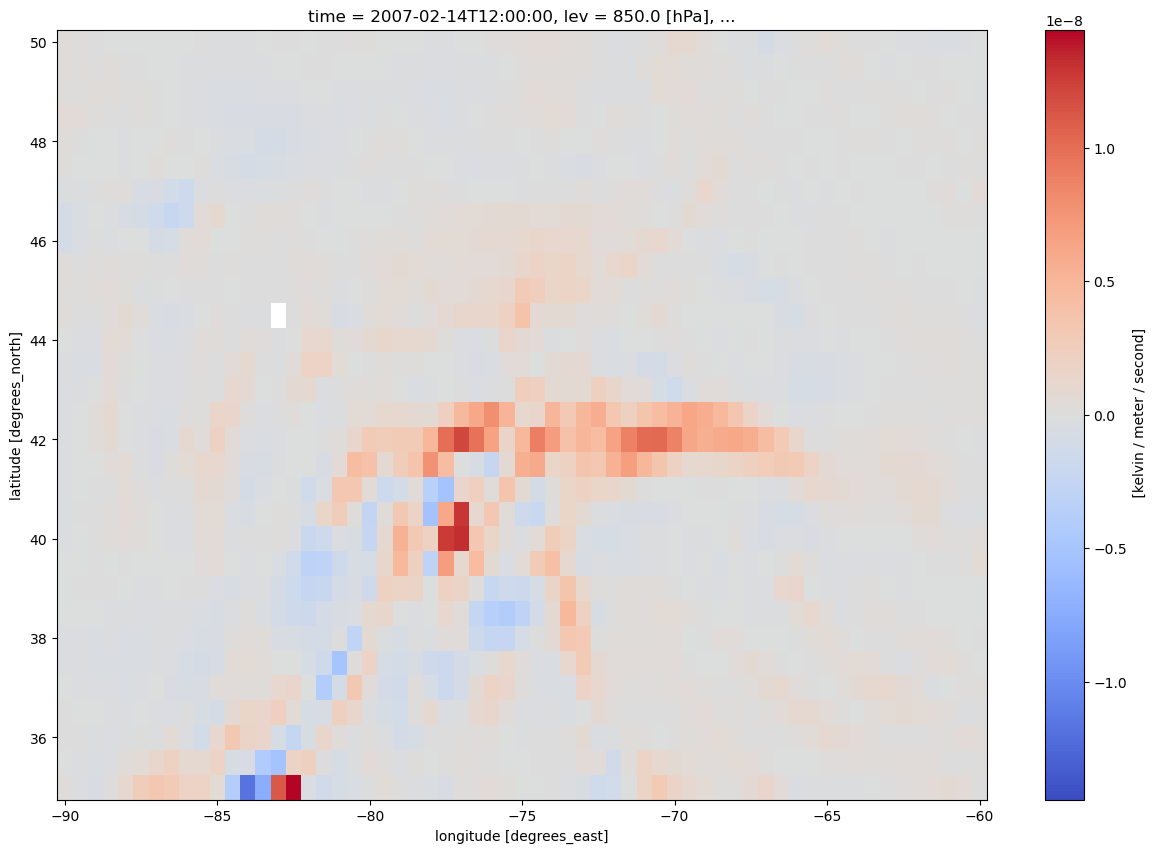

In [16]:
frnt.plot(figsize=(15,10),cmap='coolwarm')

Note the white pixel near 44 N, 83 W. This likely is a `NaN` somehow resulting from the frontogenesis calculation.

The units are in degrees K (or C) per meter per second. Traditionally, we plot frontogenesis on more of a meso- or synoptic scale ... degrees K/C per 100 km per 3 hours. Let's simply multiply by the conversion factor.

In [17]:
# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3
frnt = frnt * convert_to_per_100km_3h

Check the range and scale of values.

In [18]:
frnt.min().values, frnt.max().values

(array(-12.74713155), array(15.57214382))

A scale of 1 (i.e., 1x10^0, AKA 1e0) looks appropriate.

In [19]:
scale = 1e0

### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [20]:
frntInc = 3
negFrntContours = np.arange (-18, 0, frntInc)
posFrntContours = np.arange (3, 21, frntInc)

### Now, let's plot frontogenesis on the map. 

Processing 2007-02-14 12:00:00


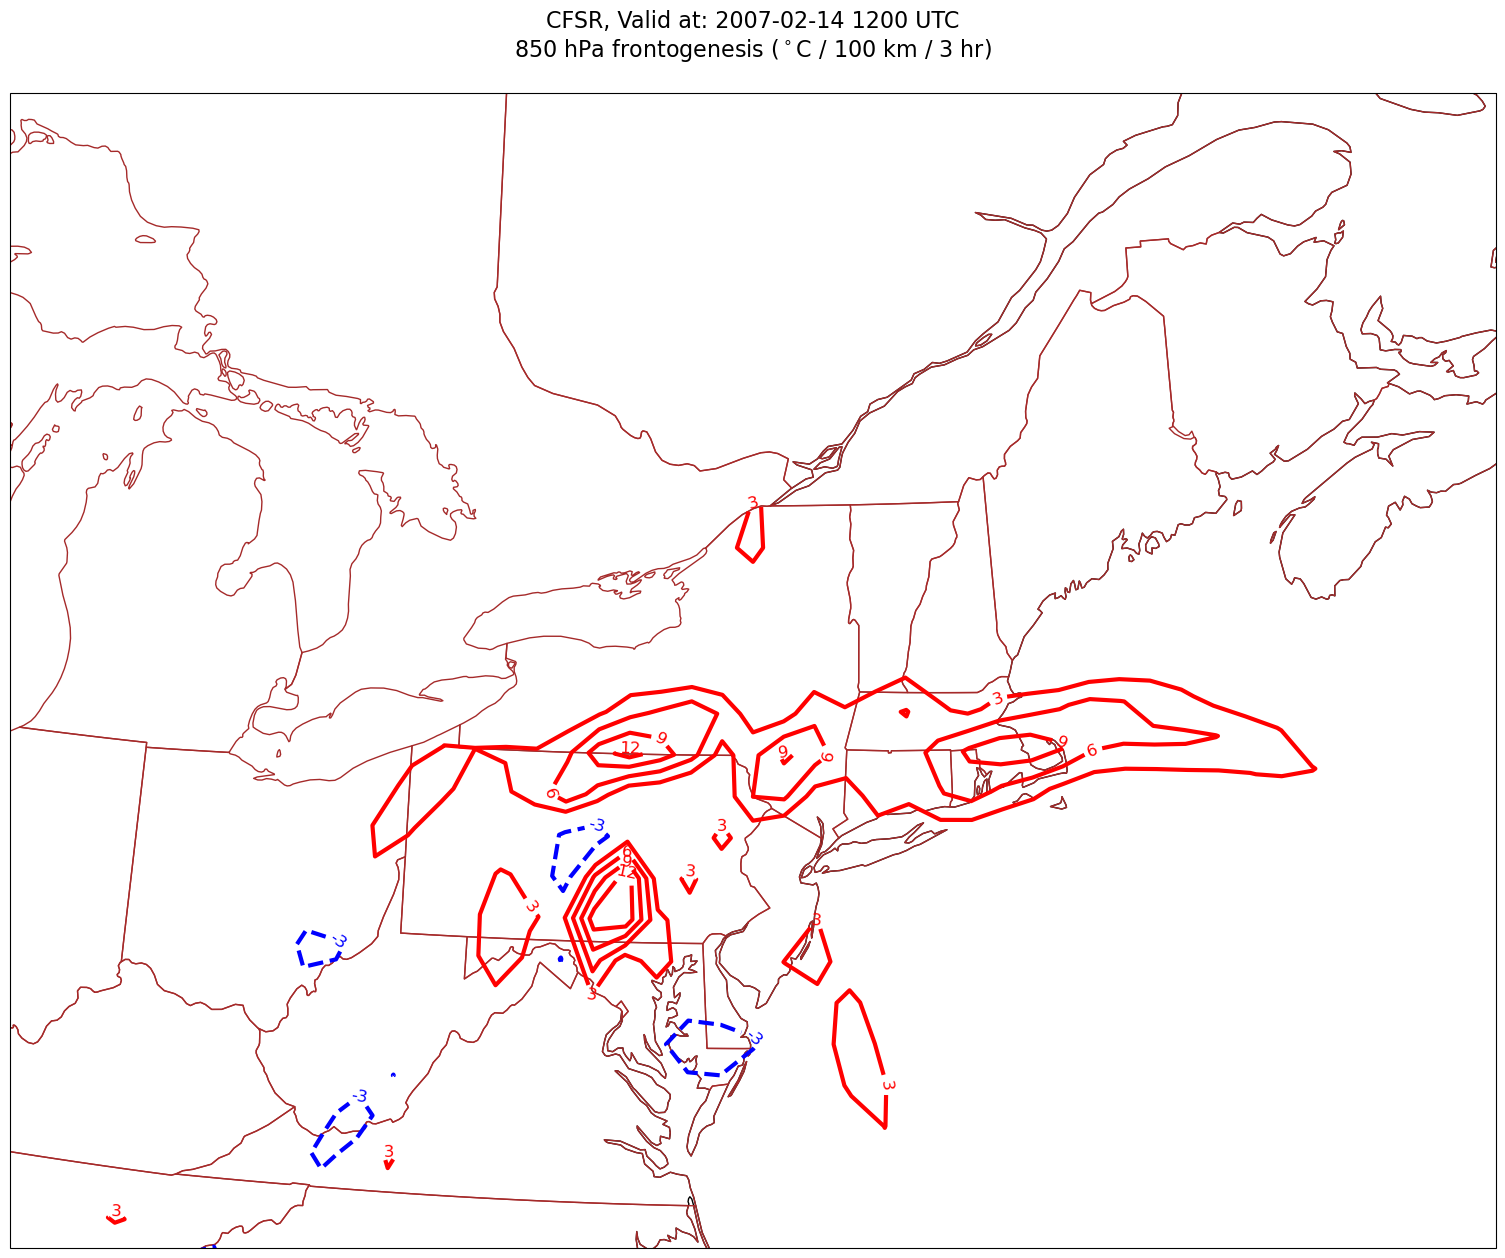

In [21]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa frontogenesis ($^\circ$C / 100 km / 3 hr)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_Frnt.png'
    fig.savefig(fileName)


# <span style="color:purple">4. Smooth the diagnostic field.</span>

Use [MetPy's implementation of a Gaussian smoother](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.smooth_gaussian.html).

In [22]:
sigma = 10.0 # this depends on how noisy your data is, adjust as necessary
frntSmth = mpcalc.smooth_gaussian(frnt, sigma)

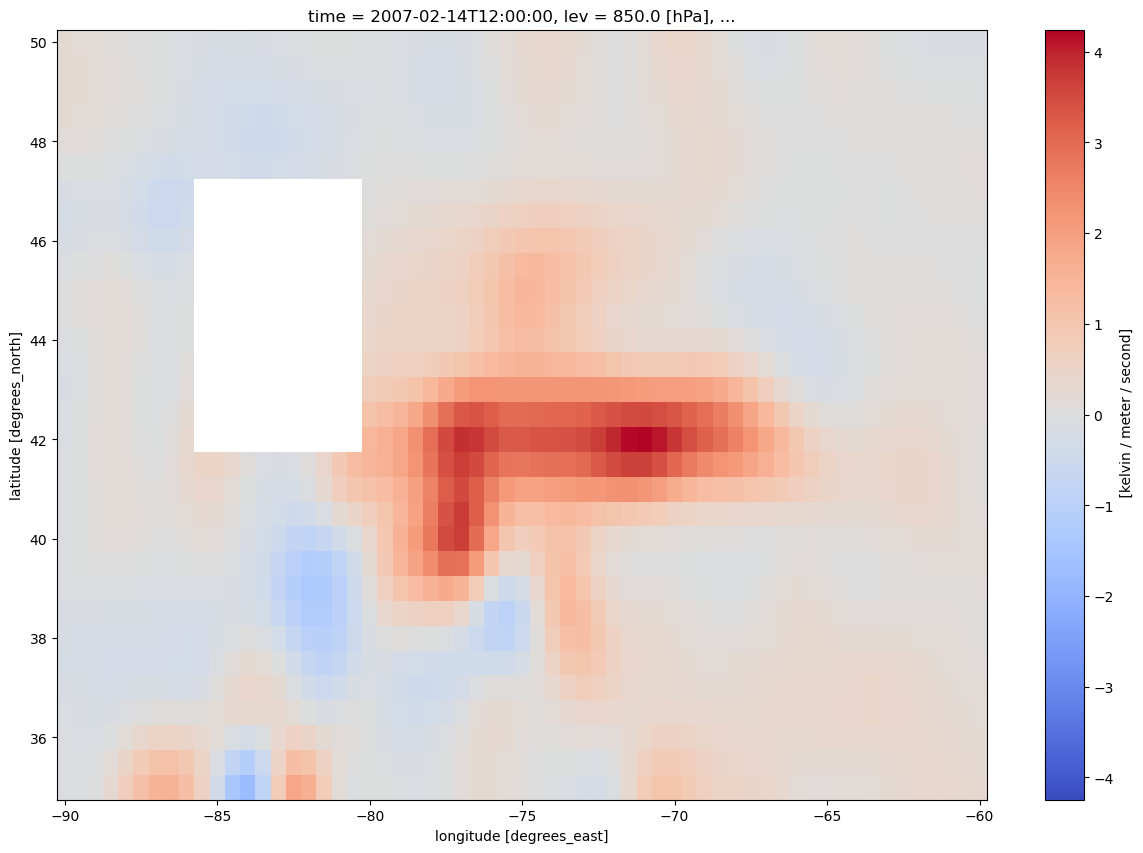

In [23]:
frntSmth.plot(figsize=(15,10),cmap='coolwarm')

Plot the smoothed field.

Processing 2007-02-14 12:00:00


/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


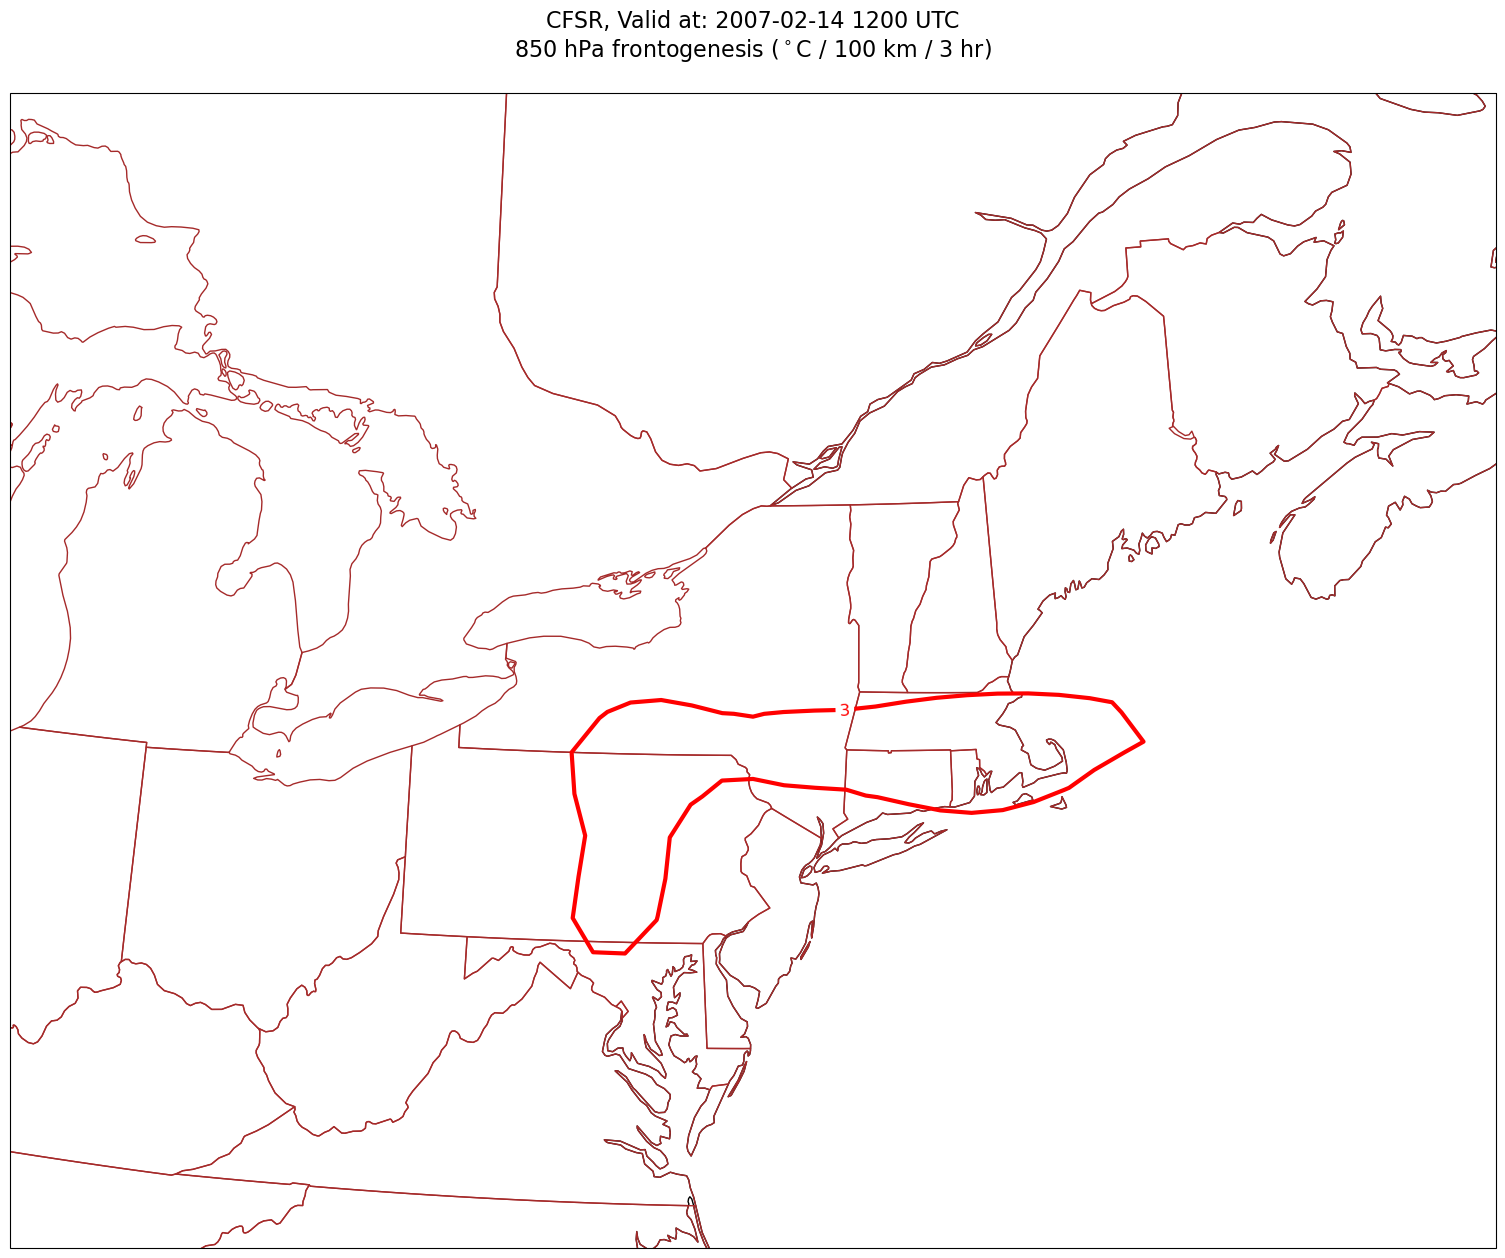

In [24]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa frontogenesis ($^\circ$C / 100 km / 3 hr)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_Frnt.png'
    fig.savefig(fileName)
